# Cats and dogs with linear regression

In [1]:
import numpy as np
from numpy.random import random, permutation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix
import itertools


Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr

def ConvBlock(model, layers, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def BuildVGG():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(224,224,3)))
    ConvBlock(model, 2, 64)
    ConvBlock(model, 2, 128)
    ConvBlock(model, 3, 256)
    ConvBlock(model, 3, 512)
    ConvBlock(model, 3, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))

    model.load_weights('/data/trained_models/vgg16_tf.h5')
    model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model



In [ ]:
model = BuildVGG()

In [5]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 224, 224, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 226, 226, 3)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 224, 224, 64)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 226, 226, 64)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [4]:
import json 
with open('/data/trained_models/imagenet_class_index.json') as f:
    class_dict = json.load(f)
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [5]:
sample_valid_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/sample/valid', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=True, 
    batch_size=8
)

sample_train_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/sample/train', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=True, 
    batch_size=8
)

Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [3]:
import math
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None, sub_titles=None, grayscale=False, cmap=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3 and not grayscale):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        if titles is not None:
            sp.set_title(titles[i], fontsize=14)
        if sub_titles is not None:
            sp.set_title(titles[i] + " (" + sub_titles[i] + ")", fontsize=14)
        plt.imshow(ims[i], interpolation=None if interp else 'none', cmap=cmap)

In [7]:
imgs, original_label_ids = next(sample_valid_batches)
preds = model.predict(imgs)
labels = np.vectorize(lambda x: classes[x])(np.argmax(preds, axis=1))

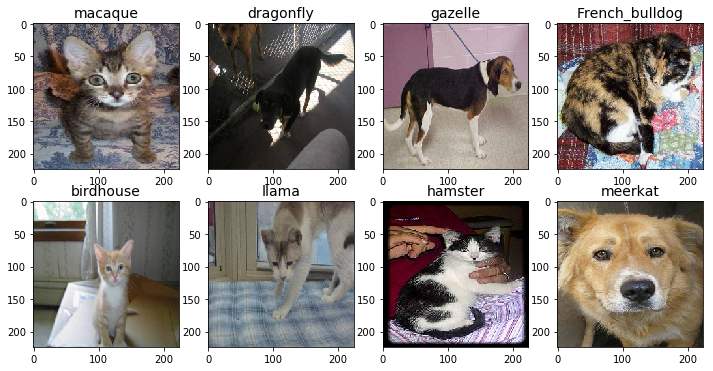

In [8]:
plots(imgs, titles=labels, rows=2)

# Precalculate one before last layer

I would like to first train just the last layer really quickly, so let's precalculate results there

In [9]:
# find the index of the flatten layer
original_layers = model.layers
flatten = [x for x in original_layers if x.name == 'flatten_1'][0]
flatten_idx = original_layers.index(flatten)

In [10]:
conv_layers = original_layers[:flatten_idx+1]
fc_layers = original_layers[flatten_idx+1:]

Create model with layers before flatten only

In [11]:
conv_model = Sequential(conv_layers)

Load images, and calculate intermediate result

In [8]:
valid_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/valid', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=False, 
    batch_size=32
)

train_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/train', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=False, 
    batch_size=32
)

Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.


In [14]:
valid_features = conv_model.predict_generator(valid_batches, valid_batches.nb_sample)
train_features = conv_model.predict_generator(train_batches, train_batches.nb_sample)

Save result

In [4]:
import bcolz

In [14]:
c = bcolz.carray(valid_features,rootdir='/data/precalc_conv_layers_valid.bc', mode='w')
c.flush()
c = bcolz.carray(train_features,rootdir='/data/precalc_conv_layers_train.bc', mode='w')
c.flush()

NameError: name 'valid_features' is not defined

Load the result back 

In [5]:
valid_features = bcolz.open('/data/precalc_conv_layers_valid.bc')[:]
train_features = bcolz.open('/data/precalc_conv_layers_train.bc')[:]

# Pretrain finale layers with precalculated data

In [6]:
fc_model = Sequential([
    Dense(4096, input_shape=(25088,), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4096, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax'),
])

fc_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
fc_model.summary()

In [ ]:
fc_model.load_weights('/data/trained_models/dog_cat_retrain_v2.1.h5')

In [9]:
result = fc_model.fit(
    train_features, 
    to_categorical(train_batches.classes), 
    validation_data=(valid_features, to_categorical(valid_batches.classes)),
    nb_epoch=1
)
#fc_model.save_weights('/data/trained_models/dog_cat_retrain_v2.2.h5')

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 110s - loss: 0.4109 - acc: 0.8961 - val_loss: 0.2054 - val_acc: 0.9265

In [ ]:
fc_model.evaluate(train_features, to_categorical(train_batches.classes))

In [ ]:
fc_model.evaluate(valid_features, to_categorical(valid_batches.classes))

In [ ]:
fc_model.optimizer.lr = 0.0001

# Train entire model

In [5]:
# Build new model
cd_model = BuildVGG()
cd_model.pop()
cd_model.pop()
cd_model.pop()
cd_model.pop()
cd_model.pop()
cd_model.add(Dense(4096, activation='relu'))
cd_model.add(BatchNormalization())
cd_model.add(Dropout(0.3))
cd_model.add(Dense(4096, activation='relu'))
cd_model.add(BatchNormalization())
cd_model.add(Dropout(0.3))
cd_model.add(Dense(2, activation='softmax'))
cd_model.compile(optimizer=Adam(lr=0.00001),loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Transfer weights
for i in range(7):
    cd_model.layers[-(1+i)].set_weights(fc_model.layers[-(i+1)].get_weights())

In [15]:
cd_model.evaluate_generator(valid_batches,2000)

[0.24280312305083498, 0.93400000000000005]

In [6]:
cd_model.load_weights('/data/trained_models/dog_cat_complete_retrain_model_v2.15.h5')

In [9]:
cd_model.evaluate_generator(valid_batches,2000)

[0.047040261209011079, 0.98299999999999998]

In [ ]:
train_batches_augmented = image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    dim_ordering='tf'
).flow_from_directory(
    '/data/dogscats/train', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=True, 
    batch_size=32
)

In [20]:
cd_model.fit_generator(train_batches_augmented, 
                 samples_per_epoch=train_batches.nb_sample/10,
                 nb_epoch=1, 
                 validation_data=valid_batches, 
                 nb_val_samples=valid_batches.nb_sample
                )

Epoch 1/1
2272/2300 [============================>.] - ETA: 1s - loss: 0.2032 - acc: 0.9318  

/opt/conda/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


2304/2300 [==============================] - 162s - loss: 0.2023 - acc: 0.9314 - val_loss: 0.1095 - val_acc: 0.9688


In [ ]:
# cd_model.save_weights('/data/trained_models/dog_cat_complete_retrain_model_v1.0.h5')

# Submit to kaggle

In [10]:
test_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/test1', 
    target_size=(224,224),
    class_mode=None, 
    shuffle=False, 
    batch_size=32
)

Found 12500 images belonging to 1 classes.


In [11]:
test_batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in test_batches.filenames])

In [12]:
results = cd_model.predict_generator(test_batches, test_batches.nb_sample)

In [48]:
def clip(x):
    if x < 0.0001:
        return 0.0001
    if x > 0.9999: 
        return 0.9999
    return x

cliped_data = [[ids[i], clip(results[i][1])] for i in range(ids.shape[0])]

In [19]:
data = [[ids[i], 0.017 if results[i][1] < 0 else 0.983] for i in range(ids.shape[0])]

In [20]:
data[:5]

[[11484, 0.983], [6593, 0.983], [10387, 0.983], [9711, 0.983], [5225, 0.983]]

In [21]:
np.savetxt('/data/dogscats/test_result_rounded.csv', data ,fmt='%d,%.5f', header='id,label')

In [56]:
from IPython.display import FileLink
FileLink('/data/dogscats/test_sorted_result.csv')

/data/dogscats/test_sorted_result.csv

# Validating the restuls

In [9]:
suffled_valid_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/my_photos', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=False, 
    batch_size=8
)

Found 2000 images belonging to 2 classes.


In [10]:
imgs, original_ids = next(suffled_valid_batches)
dog_cat_result = cd_model.predict(imgs)
dog_cat_label = np.vectorize(lambda x: ['cat','dog'][x])(np.argmax(dog_cat_result, axis=1))

In [11]:
plots(imgs, titles=dog_cat_label, rows=2)

NameError: name 'plots' is not defined

# Confusion matrix

In [122]:
valid_batches = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/valid', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=False, 
    batch_size=32
)
valid_preds = cd_model.predict_generator(valid_batches, valid_batches.nb_sample)

Found 2000 images belonging to 2 classes.


In [146]:
preds = np.argmax(valid_preds, axis=1)
valid_labels = valid_batches.classes
probs = valid_preds[:,1]

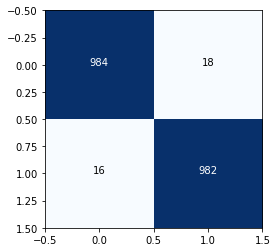

In [147]:
cm = confusion_matrix(preds,valid_labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")

# A few more examples

It's a good idea to see where our model is most certain about it's decisions, and where it is relatively uncertain.

In [51]:
filenames = image.ImageDataGenerator().flow_from_directory(
    '/data/dogscats/valid', 
    target_size=(224,224),
    class_mode='categorical', 
    shuffle=False, 
).filenames

Found 2000 images belonging to 2 classes.


In [52]:
def plots_idx(idx, titles=None, rows=1, figsize=(12,6)):
    plots([image.load_img('/data/dogscats/valid/' + filenames[i]) for i in idx], titles=titles, rows=rows, figsize=figsize)

## Random correctly labelled

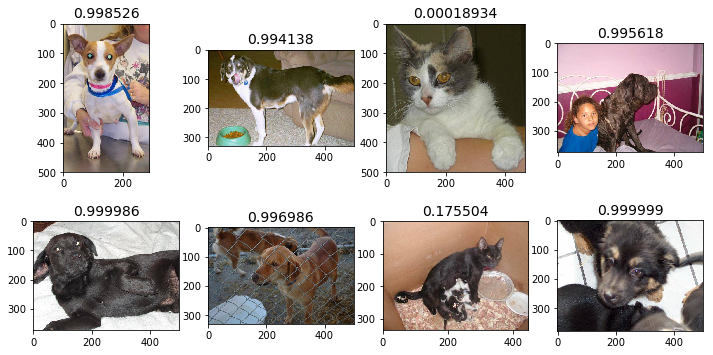

In [185]:
correct = np.where(preds==valid_labels)[0]
correct_idx = permutation(correct)[:8]
plots_idx(correct_idx, titles=probs[correct_idx], rows=2)

## Most confident about correct answer

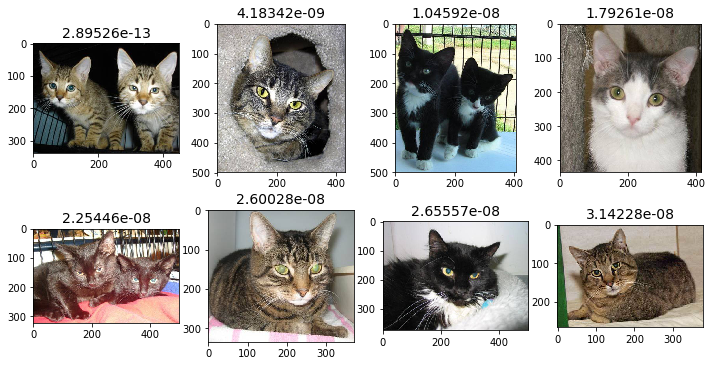

In [158]:
correct_cats = np.where((preds==0) & (preds==valid_labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[:8]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats], rows=2)

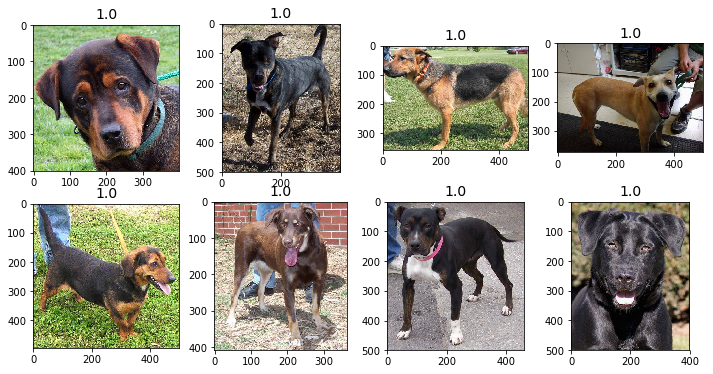

In [153]:
correct_dogs = np.where((preds==1) & (preds==valid_labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[::-1][:8]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs], rows=2)

## All the wrong answers

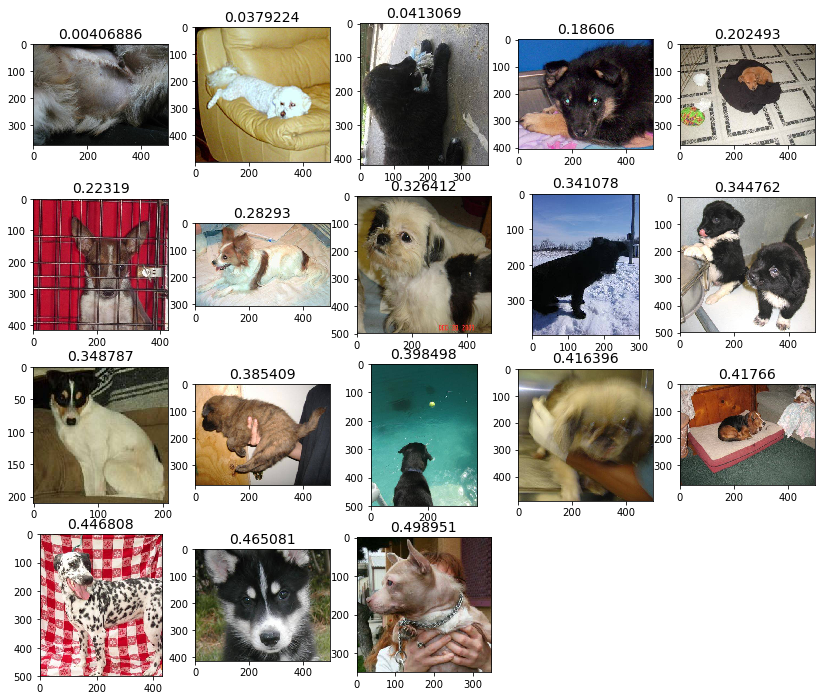

In [191]:
incorrect_cats = np.where((preds==0) & (preds!=valid_labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats], rows=4,figsize=(14,12))

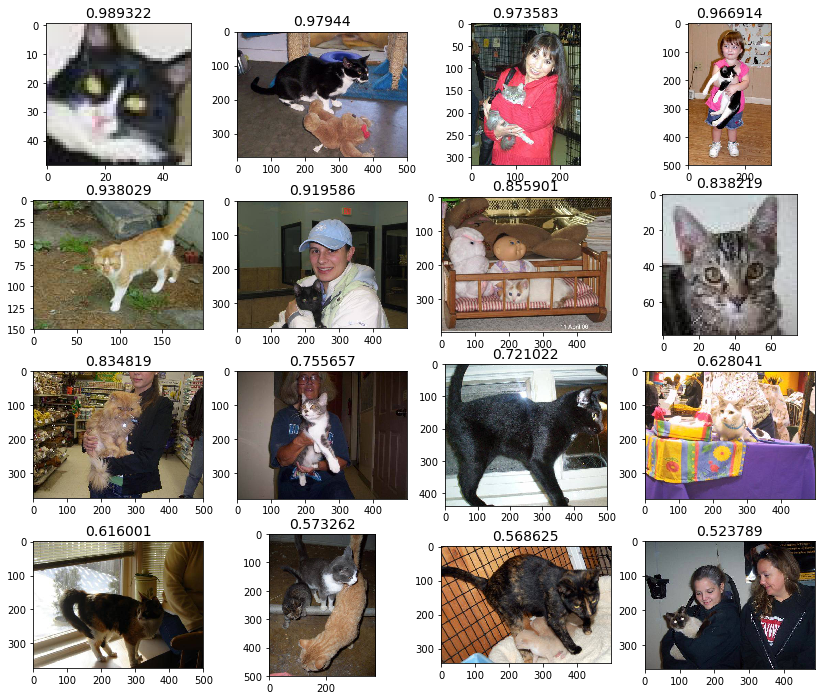

In [188]:
incorrect_dogs = np.where((preds==1) & (preds!=valid_labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[::-1]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs],rows=4,figsize=(14,12))

## Most uncertain

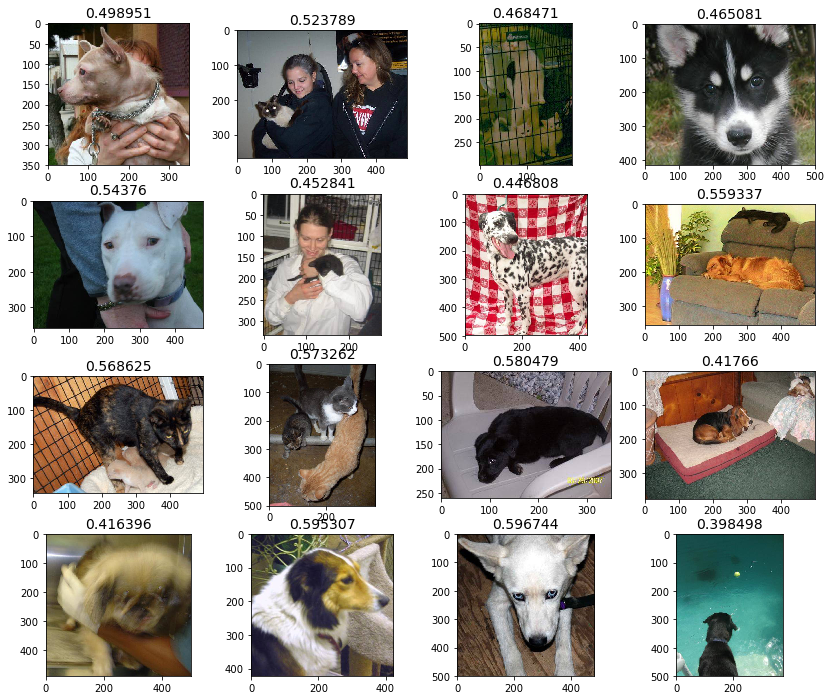

In [193]:
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:16], probs[most_uncertain], rows=4, figsize=(14,12))

# Look at the test set

In [12]:
test_results = np.loadtxt('/data/dogscats/test_result_noclip.csv', delimiter=',')

In [41]:
confident_dogs = test_results[test_results[:,1] > 0.9]
confident_cats = test_results[test_results[:,1] < 0.1]
most_uncertain = test_results[(test_results[:,1] > 0.4) & (test_results[:,1] < 0.6)]

In [43]:
confident_cats.shape

(5926, 2)

In [74]:
random_dogs = permutation(confident_dogs)[:16]
random_cats = permutation(confident_cats)[:16]
random_uncerain = permutation(most_uncertain)[:16]

In [70]:
def plots_test_by_idx(idx, titles=None, rows=1, figsize=(12,6)):
    plots([image.load_img('/data/dogscats/test1/unknown/' + str(i) + '.jpg') for i in idx], titles=titles, rows=rows, figsize=figsize)

## Certain dogs

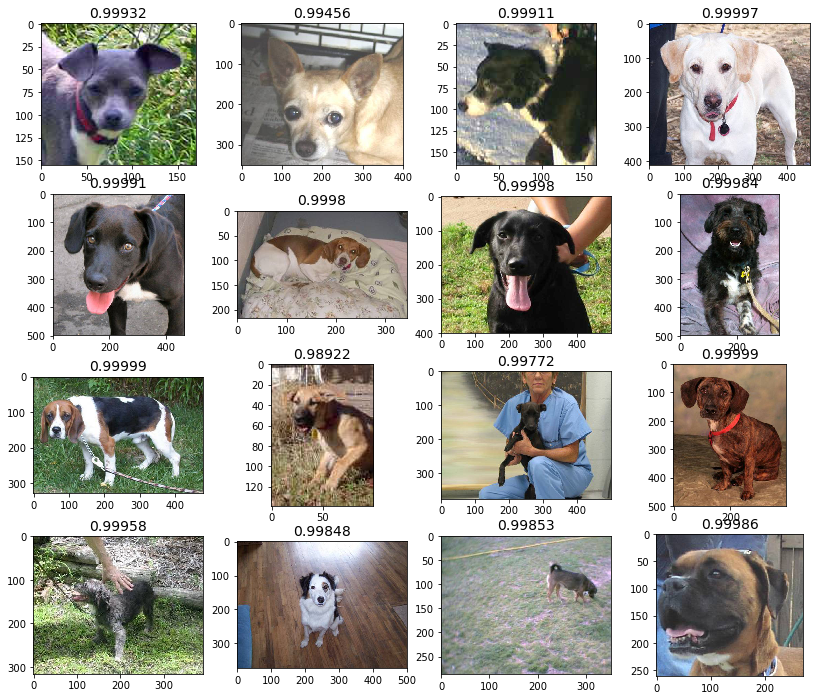

In [75]:
plots_test_by_idx(random_dogs[:,0].astype(int), titles=random_dogs[:,1], rows=4, figsize=(14,12))

## Certain cats

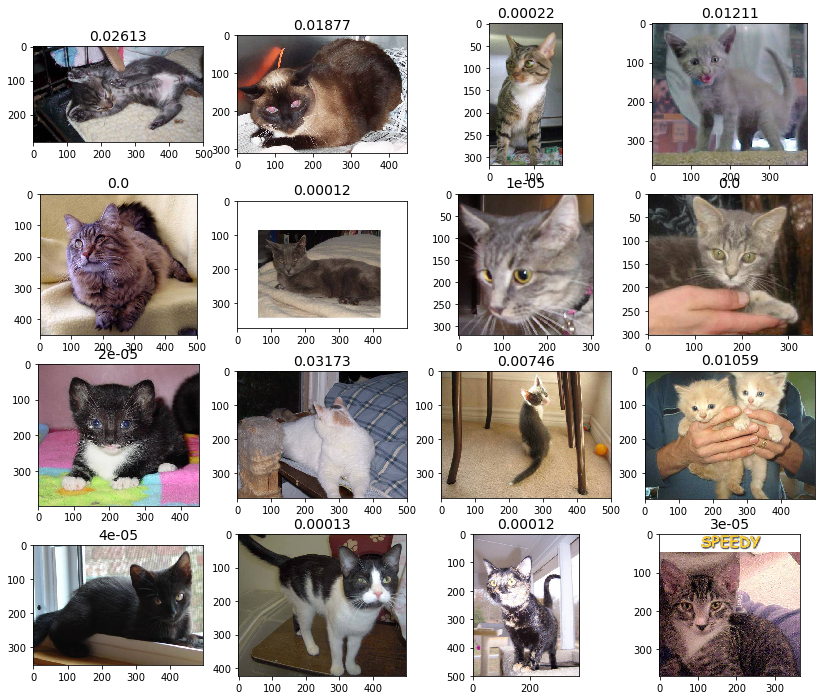

In [76]:
plots_test_by_idx(random_cats[:,0].astype(int), titles=random_cats[:,1], rows=4, figsize=(14,12))

## Uncertain

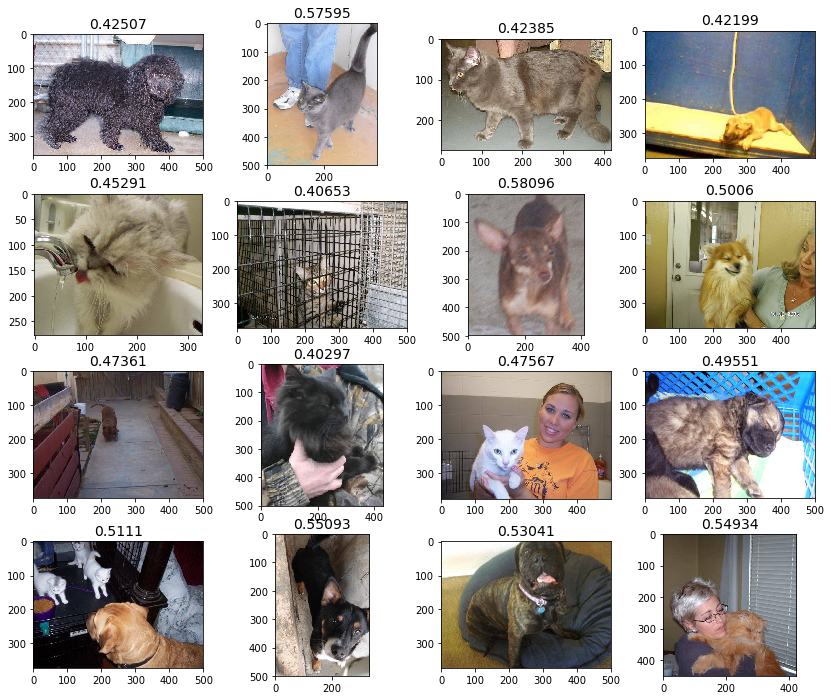

In [77]:
plots_test_by_idx(random_uncerain[:,0].astype(int), titles=random_uncerain[:,1], rows=4, figsize=(14,12))